In [17]:
#loading data

from preprocessing import read_consumption_data
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
df = read_consumption_data()
df

,time,location,consumption,temperature
0,2022-04-07 21:00:00,bergen,1.113325,-0.3
1,2022-04-07 21:00:00,oslo,4.092830,1.0
2,2022-04-07 21:00:00,stavanger,2.057858,1.3
3,2022-04-07 21:00:00,tromsø,1.246582,-3.9
4,2022-04-07 21:00:00,trondheim,1.970098,-2.8
...,...,...,...,...
49489,2023-04-02 21:00:00,helsingfors,6.333000,-1.1
49490,2023-04-02 21:00:00,oslo,12.134655,-1.1
49491,2023-04-02 21:00:00,stavanger,5.622820,0.5
49492,2023-04-02 21:00:00,tromsø,2.018333,-2.5


## Baseline 

In [18]:
from sklearn.metrics import mean_squared_error


df["hour"] = df["time"].dt.strftime("%H")
df["weekday"] = df["time"].dt.day_name()
df["baseline_prediction"] = df.groupby(["location", "hour", "weekday"])["consumption"].shift(1)

df = df[~df["baseline_prediction"].isna()]

mape = np.mean(np.abs((df["consumption"] - df["baseline_prediction"]) / df["consumption"]))
rmse = np.sqrt(mean_squared_error(df["consumption"], df["baseline_prediction"]))
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")


RMSE: 0.6811623559435133
MAPE: 0.1083910536600149


#### Helsingfors Consumption

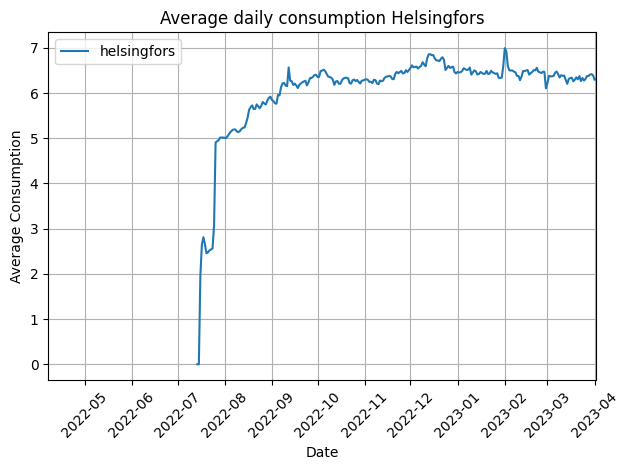

In [19]:

#plotting the consumption for Helsingfors:
df = read_consumption_data()
date_range = pd.date_range(start=df["time"].dt.date.min(), 
                          end=df["time"].dt.date.max())

daily_avg_consumption= (
    df.groupby([df["time"].dt.date, "location"])["consumption"].mean().unstack()
)


daily_avg_consumption_helsingfors = daily_avg_consumption.reindex(date_range)

plt.plot(date_range, daily_avg_consumption_helsingfors["helsingfors"], label = "helsingfors")
plt.title("Average daily consumption Helsingfors")
plt.xlabel("Date")
plt.ylabel("Average Consumption")
plt.legend()
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.xlim(date_range.min(), date_range.max())
plt.tight_layout()
plt.show()


#### Consumption all cities

location      bergen  helsingfors      oslo  stavanger    tromsø  trondheim
time                                                                       
2022-04-07  1.057482          NaN  3.857302   1.932868  1.188618   1.852405
2022-04-08  1.025314          NaN  3.844801   1.866316  1.156766   1.875748
2022-04-09  1.097857          NaN  3.689813   1.885124  1.092602   1.804450
2022-04-10  1.080573          NaN  3.254670   1.753968  1.086494   1.776716
2022-04-11  1.034815          NaN  3.100625   1.643581  1.061387   1.793448


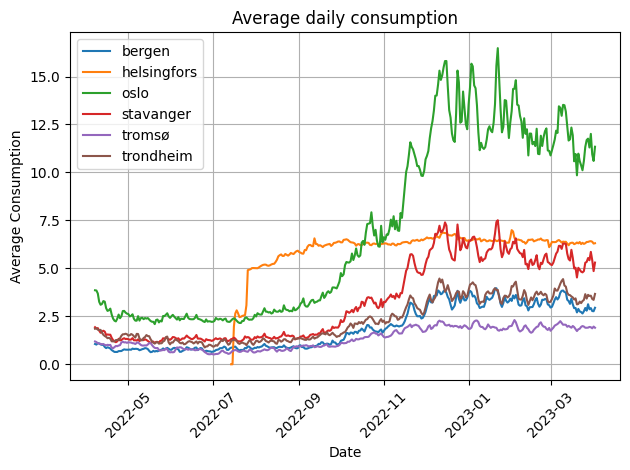

In [20]:
# Plotting average consumprtion for all cities:

daily_avg_consumption= (
    df.groupby([df["time"].dt.date, "location"])["consumption"].mean().unstack()
)
print(daily_avg_consumption.head())
for city in daily_avg_consumption.columns:
    plt.plot(daily_avg_consumption.index, daily_avg_consumption[city], label = city)
plt.title("Average daily consumption")
plt.xlabel("Date")
plt.ylabel("Average Consumption")
plt.legend()
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Consumption and temperature Season

In [21]:
# Function defining what season a datapoint belongs to 
def get_season(month, day):
    if  month == 3 or month == 4 or month == 5:
        return 'Spring'
    elif month == 6 or month == 7 or month == 8:
        return 'Summer'
    elif month == 9 or month == 10 or month == 11:
        return 'Fall'
    else:
        return 'Winter'


#adding season coloumn
df['season'] = df.apply(lambda row: get_season(row['time'].month, row['time'].day), axis=1)


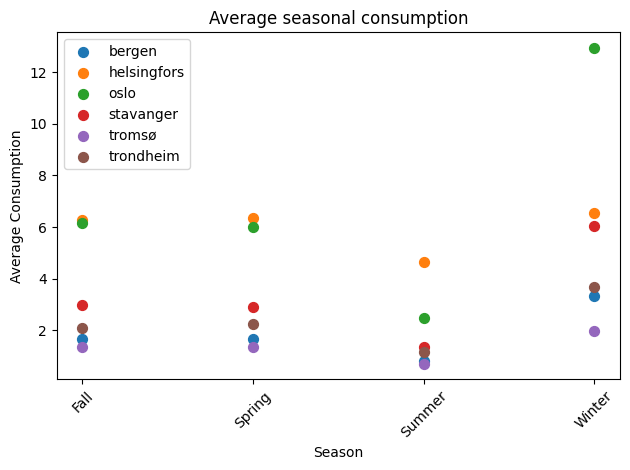

In [22]:
# Plotting average consumption for the cities based on what season it is:
season_avg_consumption= (
    df.groupby([df["season"], "location"])["consumption"].mean().unstack()
)

for city in season_avg_consumption.columns:
    plt.scatter(season_avg_consumption.index, season_avg_consumption[city], label = city, marker='o', s=50)
plt.title("Average seasonal consumption")
plt.xlabel("Season")
plt.ylabel("Average Consumption")
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

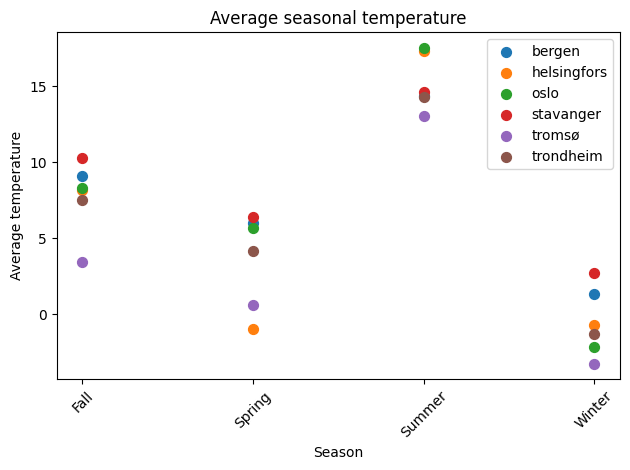

In [23]:
# Plotting average consumption for the cities based on what season it is:
season_avg_temperature= (
    df.groupby([df["season"], "location"])["temperature"].mean().unstack()
)

# print(season_avg_temperature.loc["Spring"].tolist())

# print(season_avg_temperature.head())


# Create a scatter plot for each city
for city in season_avg_temperature.columns:
    plt.scatter(season_avg_temperature.index, season_avg_temperature[city], label = city, marker='o', s=50)

# Set x-axis labels to be the seasons

plt.title("Average seasonal temperature")
plt.xlabel("Season")
plt.ylabel("Average temperature")
plt.legend()
# plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# df.drop("season", axis=1, inplace=True)




#### Average temperature


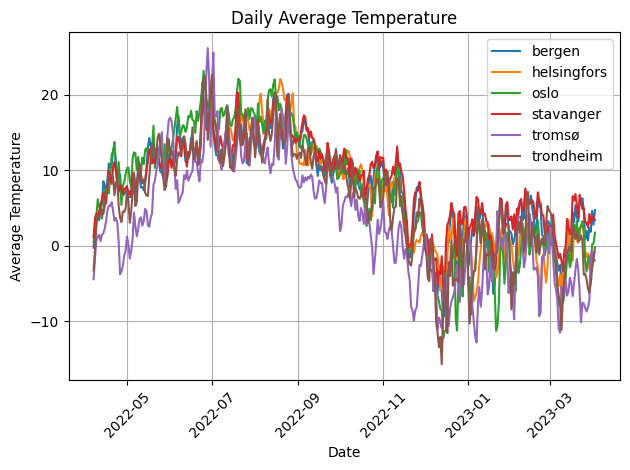

In [24]:
#plotting the daily average temperature for thw whole period
daily_avg_temp = (
    df.groupby([df["time"].dt.date, "location"])["temperature"].mean().unstack()
)
# Loop through each city and plot its daily average temperature
for city in daily_avg_temp.columns:
    plt.plot(daily_avg_temp.index, daily_avg_temp[city], label=city)

# Customize the plot
plt.title("Daily Average Temperature")
plt.xlabel("Date")
plt.ylabel("Average Temperature")
plt.legend()
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Normalized average temperature vs. normalized consumption

In [25]:
df = read_consumption_data()

#removing helsingfors

df = df[df["location"] != "helsingfors"]


scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

#normalizing temperature overall
df['Temperature_Normalized'] = scaler1.fit_transform(df['temperature'].values.reshape(-1, 1))
#normalizing consumption within each city
df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler2.fit_transform(x.values.reshape(-1, 1))])

print("The total correlation between temperature and consumption is: ", df["Temperature_Normalized"].corr(df["Consumption_Normalized"]))

df.drop("temperature", inplace=True, axis=1)
df.drop("consumption", inplace=True, axis=1)

# df.head()


The total correlation between temperature and consumption is:  -0.8269031450563769


C:\Users\siver\AppData\Local\Temp\ipykernel_1992\3308161425.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler2.fit_transform(x.values.reshape(-1, 1))])
C:\Users\siver\AppData\Local\Temp\ipykernel_1992\3308161425.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  df['Consumption_Normalized'] = df.groupby('location')['consumption'].transform(lambda x: [float(val) for val in scaler2.fit_transform(x.values.reshape(-1, 1))])
C:\Users\siver\AppData\Local\Temp\ipykernel_1992\3308161425.py:14: DeprecationWarning: Conversion 

location      bergen      oslo  stavanger    tromsø  trondheim
time                                                          
2022-04-07  0.356346  0.373780   0.384240  0.269177   0.292887
2022-04-08  0.412744  0.390342   0.438808  0.327842   0.352075
2022-04-09  0.431921  0.445084   0.450750  0.378400   0.416928
2022-04-10  0.443950  0.490324   0.444125  0.386593   0.445258
2022-04-11  0.432967  0.469404   0.458333  0.392434   0.437500
...              ...       ...        ...       ...        ...
2023-03-29  0.411437  0.333333   0.450227  0.211036   0.231695
2023-03-30  0.400366  0.304480   0.423727  0.338476   0.256712
2023-03-31  0.458595  0.366196   0.446740  0.345624   0.299773
2023-04-01  0.420328  0.367591   0.436192  0.324965   0.324965
2023-04-02  0.460822  0.398155   0.433245  0.321225   0.357075

[361 rows x 5 columns]


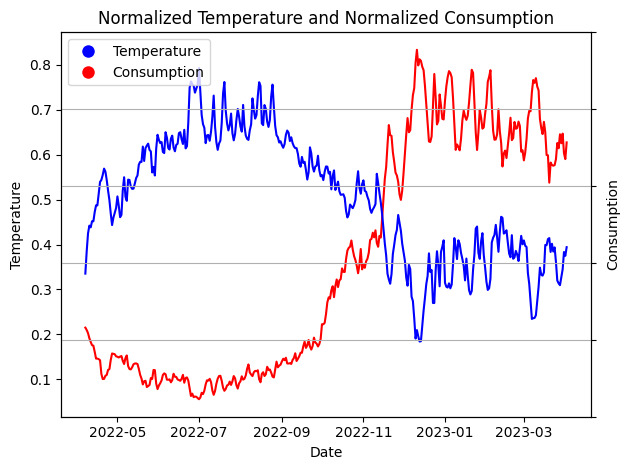

In [27]:
# making daily avg plots

#dropping helsingfors
from matplotlib.lines import Line2D


df = df[df["location"] != "helsingfors"]


daily_avg_temp = (
    df.groupby([df["time"].dt.date, "location"])["Temperature_Normalized"].mean().unstack()
)

print(daily_avg_temp)

# Create custom legend handles
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Temperature'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Consumption')
]

# Create custom legend labels
labels = ['Temperature', 'Consumption']

daily_avg_consumption= (
    df.groupby([df["time"].dt.date, "location"])["Consumption_Normalized"].mean().unstack()
)
# Loop through each city and plot its daily average temperature
# i = 0
# for city in daily_avg_temp.columns:
#     if i == 0:
#         plt.plot(daily_avg_temp.index, daily_avg_temp[city], color="blue", label="temperature")
#     else:
#         plt.plot(daily_avg_temp.index, daily_avg_temp[city], color="blue")
#     i+=1

# i = 0
# for cith in daily_avg_consumption.columns:
#     if i==0:
#         plt.plot(daily_avg_consumption.index, daily_avg_consumption[city], color="red", label="consumption")
#     else:
#         plt.plot(daily_avg_consumption.index, daily_avg_consumption[city], color="red")
#     i+=1

#taking the average normalized consumption per city
daily_avg_consumption_avg_cities = (
    df.groupby([df["time"].dt.date])["Consumption_Normalized"].mean()
)
plt.plot(daily_avg_consumption_avg_cities.index, daily_avg_consumption_avg_cities, color="red", label="Consumption")

# taking the average normalized temperature per city
daily_avg_temp_avg_cities = (
    df.groupby([df["time"].dt.date])["Temperature_Normalized"].mean()
)
plt.plot(daily_avg_temp_avg_cities.index, daily_avg_temp_avg_cities, color="blue", label="Temperature")
# Customize the plot
plt.title("Normalized Temperature and Normalized Consumption")
plt.xlabel("Date")
#left y label for temperature and right y label for consumption
ax = plt.gca()
ax2 = ax.twinx()
ax.set_ylabel("Temperature")
ax2.set_ylabel("Consumption")
#hide numbers on y axis
ax2.set_yticklabels([])

plt.legend(handles=handles, labels=labels, loc="upper left")
plt.grid(True)

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

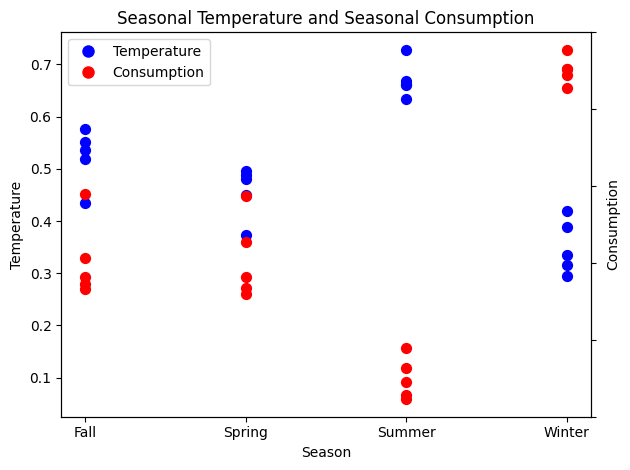

In [28]:
# doing same but seasonal
from matplotlib.lines import Line2D


df['season'] = df.apply(lambda row: get_season(row['time'].month, row['time'].day), axis=1)

season_avg_temperature= (
    df.groupby([df["season"], "location"])["Temperature_Normalized"].mean().unstack()
)

season_avg_consumption= (
    df.groupby([df["season"], "location"])["Consumption_Normalized"].mean().unstack()
)

# Create custom legend handles
handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Temperature'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Consumption')
]

# Create custom legend labels
labels = ['Temperature', 'Consumption']

i=0
for city in season_avg_temperature.columns:
    if i==0:
        plt.scatter(season_avg_temperature.index, season_avg_temperature[city], label = "temperature", marker='o', s=50, color="blue")
    else:
        plt.scatter(season_avg_temperature.index, season_avg_temperature[city], marker='o', s=50, color="blue")
    i+=1

i = 0
for city in season_avg_consumption.columns:
    if i==0:
        plt.scatter(season_avg_consumption.index, season_avg_consumption[city], label = "consumption", marker='o', s=50, color="red")
    else:
        plt.scatter(season_avg_consumption.index, season_avg_consumption[city], marker='o', s=50, color="red")
    i+=1


        
plt.title("Seasonal Temperature and Seasonal Consumption")
plt.xlabel("Season")
ax = plt.gca()
ax2 = ax.twinx()
ax.set_ylabel("Temperature")
ax2.set_ylabel("Consumption")
#hide numbers on y axis
ax2.set_yticklabels([])
plt.legend(handles=handles, labels=labels, loc="upper left")

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Correlation between temperature and consumption in each city

In [105]:

#finding correlation between temperature and consumption in each location

#oslo
oslo_fall = df[(df["location"] == "oslo") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "oslo") & (df["season"] == "Fall")]["Consumption_Normalized"])
oslo_spring = df[(df["location"] == "oslo") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "oslo") & (df["season"] == "Spring")]["Consumption_Normalized"])
oslo_summer = df[(df["location"] == "oslo") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "oslo") & (df["season"] == "Summer")]["Consumption_Normalized"])
oslo_winter = df[(df["location"] == "oslo") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "oslo") & (df["season"] == "Winter")]["Consumption_Normalized"])

#trondheim
trondheim_fall = df[(df["location"] == "trondheim") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "trondheim") & (df["season"] == "Fall")]["Consumption_Normalized"])
trondheim_spring = df[(df["location"] == "trondheim") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "trondheim") & (df["season"] == "Spring")]["Consumption_Normalized"])
trondheim_summer = df[(df["location"] == "trondheim") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "trondheim") & (df["season"] == "Summer")]["Consumption_Normalized"])
trondheim_winter = df[(df["location"] == "trondheim") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "trondheim") & (df["season"] == "Winter")]["Consumption_Normalized"])

#bergen
bergen_fall = df[(df["location"] == "bergen") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "bergen") & (df["season"] == "Fall")]["Consumption_Normalized"])
bergen_spring = df[(df["location"] == "bergen") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "bergen") & (df["season"] == "Spring")]["Consumption_Normalized"])
bergen_summer = df[(df["location"] == "bergen") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "bergen") & (df["season"] == "Summer")]["Consumption_Normalized"])
bergen_winter = df[(df["location"] == "bergen") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "bergen") & (df["season"] == "Winter")]["Consumption_Normalized"])

#stavanger
stavanger_fall = df[(df["location"] == "stavanger") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "stavanger") & (df["season"] == "Fall")]["Consumption_Normalized"])
stavanger_spring = df[(df["location"] == "stavanger") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "stavanger") & (df["season"] == "Spring")]["Consumption_Normalized"])
stavanger_summer = df[(df["location"] == "stavanger") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "stavanger") & (df["season"] == "Summer")]["Consumption_Normalized"])
stavanger_winter = df[(df["location"] == "stavanger") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "stavanger") & (df["season"] == "Winter")]["Consumption_Normalized"])

#tromsø
tromsø_fall = df[(df["location"] == "tromsø") & (df["season"] == "Fall")]["Temperature_Normalized"].corr(df[(df["location"] == "tromsø") & (df["season"] == "Fall")]["Consumption_Normalized"])
tromsø_spring = df[(df["location"] == "tromsø") & (df["season"] == "Spring")]["Temperature_Normalized"].corr(df[(df["location"] == "tromsø") & (df["season"] == "Spring")]["Consumption_Normalized"])
tromsø_summer = df[(df["location"] == "tromsø") & (df["season"] == "Summer")]["Temperature_Normalized"].corr(df[(df["location"] == "tromsø") & (df["season"] == "Summer")]["Consumption_Normalized"])
tromsø_winter = df[(df["location"] == "tromsø") & (df["season"] == "Winter")]["Temperature_Normalized"].corr(df[(df["location"] == "tromsø") & (df["season"] == "Winter")]["Consumption_Normalized"])

#printing out all values in table
print("Correlation between temperature and consumption in each city during each season")
print("Oslo: ")
print("Fall: ", oslo_fall)
print("Spring: ", oslo_spring)
print("Summer: ", oslo_summer)
print("Winter: ", oslo_winter)
print()
print("Trondheim: ")
print("Fall: ", trondheim_fall)
print("Spring: ", trondheim_spring)
print("Summer: ", trondheim_summer)
print("Winter: ", trondheim_winter)
print()
print("Bergen: ")
print("Fall: ", bergen_fall)
print("Spring: ", bergen_spring)
print("Summer: ", bergen_summer)
print("Winter: ", bergen_winter)
print()
print("Stavanger: ")
print("Fall: ", stavanger_fall)
print("Spring: ", stavanger_spring)
print("Summer: ", stavanger_summer)
print("Winter: ", stavanger_winter)
print()
print("Tromsø: ")
print("Fall: ", tromsø_fall)
print("Spring: ", tromsø_spring)
print("Summer: ", tromsø_summer)
print("Winter: ", tromsø_winter)
print()


Correlation between temperature and consumption in each city during each season
Oslo: 
Fall:  -0.7597942361012443
Spring:  -0.7960825540726704
Summer:  0.30470896245690154
Winter:  -0.6646043647453427

Trondheim: 
Fall:  -0.7388198011047145
Spring:  -0.7762489119283462
Summer:  -0.14911063951586837
Winter:  -0.5464175034055018

Bergen: 
Fall:  -0.6730731142503313
Spring:  -0.7018948235141996
Summer:  0.05370827726941482
Winter:  -0.4722805858652246

Stavanger: 
Fall:  -0.7145553345761203
Spring:  -0.6945034603583227
Summer:  0.21065560456782229
Winter:  -0.5124574311777806

Tromsø: 
Fall:  -0.8333308098706039
Spring:  -0.8115267905143567
Summer:  -0.43530004054391214
Winter:  -0.5961829566573078



Violin plot temperature

C:\Users\siver\AppData\Local\Temp\ipykernel_1992\2110597524.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='month', y='temperature', palette=colors)


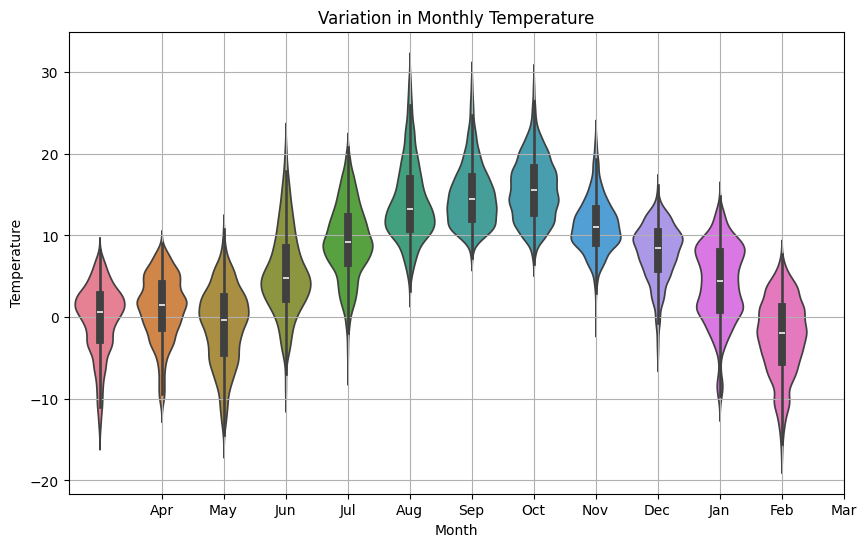

In [29]:
df = read_consumption_data()
df['month'] = df['time'].dt.month

colors = sns.color_palette("husl", 12)
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='month', y='temperature', palette=colors)
plt.title('Variation in Monthly Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.xticks(range(1, 13), ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar'])
plt.grid(True)
plt.show()



Average temperature per weekday

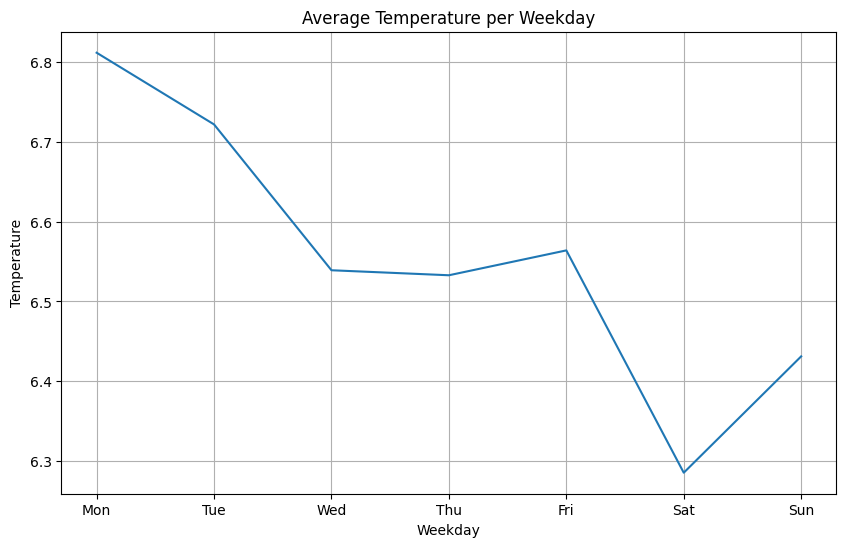

In [31]:
df = read_consumption_data()
# create a weekday column
df['weekday'] = df['time'].dt.weekday
# group on weekdays and find average temperature per weekday
weekday_avg_temp = df.groupby('weekday')['temperature'].mean().reset_index()
# plot the average temperature per weekday as a line plot
plt.figure(figsize=(10, 6))
plt.plot(weekday_avg_temp['weekday'], weekday_avg_temp['temperature'])
plt.title('Average Temperature per Weekday')
plt.xlabel('Weekday')
plt.ylabel('Temperature')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True)
plt.show()


## Correlation plot

In [74]:
from preprocessing import preprocess_consumption_data


df = read_consumption_data()
df = preprocess_consumption_data(df)
df.drop(["location", "time","weekday"], axis=1, inplace=True )
corr_matrix = df.corr()
plt.figure(figsize=(20, 20))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot')

plt.show()

Dropping 4219 of 49494 rows (9%)


ValueError: could not convert string to float: 'spring'

## Descriptive and summary statistics of dataset

In [ ]:
#Min max vanlues
min_consumption_id = df["consumption"].idxmin()
max_consumption_id = df["consumption"].idxmax()

min_consumption = df.at[min_consumption_id,"consumption"]
max_consumption = df.at[max_consumption_id,"consumption"]

print(min_consumption, "Date:", df.at[min_consumption_id,"time"])
print(max_consumption, "Date:", df.at[max_consumption_id,"time"])

KeyError: 'time'

In [ ]:
# Summary statistics
df.describe()

,time,consumption,temperature,baseline_prediction
count,47478,47478.000000,47478.000000,47478.000000
mean,2022-10-18 00:27:07.347402752,3.581094,6.516928,3.507830
min,2022-04-21 21:00:00,0.372637,-17.299999,0.372637
25%,2022-07-29 15:00:00,1.283722,0.900000,1.253472
50%,2022-10-20 01:00:00,2.442891,6.900000,2.353398
75%,2023-01-10 11:00:00,5.380018,12.100000,5.203815
max,2023-04-02 21:00:00,18.045011,30.500000,18.045011
std,NaN,3.134163,7.695729,3.105171


#### Every city 

In [ ]:
df = read_consumption_data()
df.drop("time", axis=1, inplace=True)
df_bergen = df[df["location"] == "bergen"]
df_oslo = df[df["location"] == "oslo"]
df_trondheim = df[df["location"] == "trondheim"]
df_stavanger = df[df["location"] == "stavanger"]
df_tromsø = df[df["location"] == "tromsø"]
df_helsingfors = df[df["location"] == "helsingfors"]

Bergen

In [ ]:
df_bergen.describe()

,consumption,temperature
count,8641.000000,8641.000000
mean,1.876716,7.750237
std,1.156034,6.556976
min,0.443192,-15.600000
25%,0.834003,3.100000
50%,1.380962,8.100000
75%,2.998324,12.200000
max,4.650816,29.299999


Oslo

In [ ]:
df_oslo.describe()

,consumption,temperature
count,8641.000000,8641.000000
mean,6.876428,7.392883
std,4.672634,8.770901
min,1.520560,-15.400000
25%,2.610569,0.900000
50%,4.871180,7.900000
75%,11.458471,14.200000
max,18.045011,29.799999


Trondheim

In [ ]:
df_trondheim.describe()


,consumption,temperature
count,8641.000000,8641.000000
mean,2.278574,6.213621
std,1.137311,7.616749
min,0.620001,-17.299999
25%,1.263027,1.100000
50%,1.841736,6.500000
75%,3.376217,11.600000
max,5.099158,30.500000


Stavanger

In [ ]:
df_stavanger.describe()

,consumption,temperature
count,8641.000000,8641.000000
mean,3.304703,8.547795
std,2.112962,5.839943
min,0.832372,-9.200000
25%,1.382764,4.300000
50%,2.390667,8.900000
75%,5.398822,12.700000
max,8.763147,27.000000


Tromsø

In [ ]:
df_tromsø.describe()

,consumption,temperature
count,8641.000000,8641.000000
mean,1.340776,3.514119
std,0.559151,7.967161
min,0.372637,-14.600000
25%,0.831883,-2.600000
50%,1.195308,2.800000
75%,1.874898,9.600000
max,2.552159,29.799999


Helsingfors

In [ ]:
df_helsingfors.describe()


,consumption,temperature
count,6289.000000,6289.000000
mean,6.077242,5.662903
std,0.919462,7.592141
min,0.000000,-10.100000
25%,6.189000,-0.300000
50%,6.354000,3.100000
75%,6.474000,11.600000
max,7.860000,24.000000


### Geographical map of consuption in the different cities

In [ ]:
from mpl_toolkits.basemap import Basemap

# Consuption last year for every city

print(df[df['location']=='oslo']['consumption'].sum())
# Sample data
data = {
    'City': ['Oslo', 'Trondheim', 'Bergen', 'Tromsø', 'Stavanger','Helsingfors'],
    'Latitude': [59.921669638107886, 63.42944565974513, 60.392557002128, 69.65246067890097, 58.967153190155756, 60.187855702136694],  # Replace with actual latitude values
    'Longitude': [10.75954528187801, 39.2676777695183, 5.326343793169161, 69.65246067890097, 73087196283154, 24.937767731051913],  # Replace with actual longitude values
    'TotalConsumption': [df[df['location']=='oslo']['consumption'].sum()
                         , df[df['location']=='trondheim']['consumption'].sum()
                         , df[df['location']=='bergen']['consumption'].sum()
                         , df[df['location']=='tromsø']['consumption'].sum()
                         , df[df['location']=='stavanger']['consumption'].sum()
                         , df[df['location']=='helsingfors']['consumption'].sum()]  # Replace with actual consumption values
}

df_map = pd.DataFrame(data)

# Create a Basemap
m = Basemap(
    projection='cyl',  # Cylindrical equidistant projection
    llcrnrlat=min(df['Latitude']) - 1,
    urcrnrlat=max(df['Latitude']) + 1,
    llcrnrlon=min(df['Longitude']) - 1,
    urcrnrlon=max(df['Longitude']) + 1,
    resolution='i',
)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot map background
m.drawcoastlines()
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='green', lake_color='aqua')



# Plot circles with sizes based on total consumption
for index, row in df_map.iterrows():
    ax.add_patch(plt.Circle((row['Longitude'], row['Latitude']), row['TotalConsumption'], color='blue', alpha=0.6))

# Set axis limits and labels (customize as needed)
ax.set_xlim(min(df_map['Longitude']) - 1, max(df_map['Longitude']) + 1)
ax.set_ylim(min(df_map['Latitude']) - 1, max(df_map['Latitude']) + 1)

# Display the map
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('City Consumption Map')

# Show the plot
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

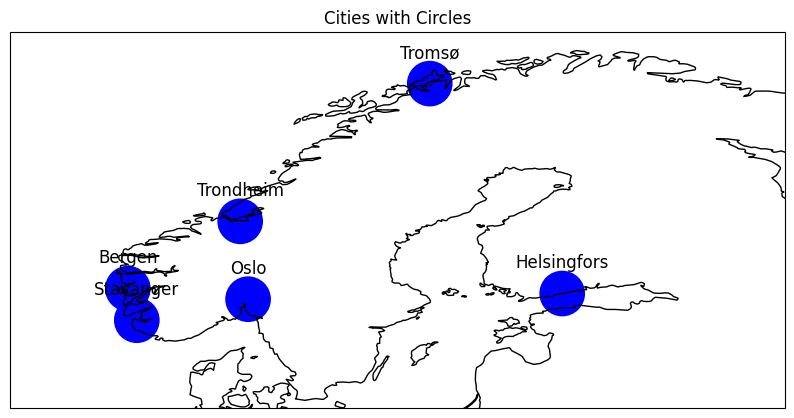

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Latitude and Longitude coordinates for 5 cities
cities = {
    "Oslo": (59.9139, 10.7522),
    "Bergen": (60.3913, 5.3221),
    "Trondheim": (63.4305, 10.3951),
    "Tromsø": (69.6496, 18.9560),
    "Stavanger": (58.9650, 5.7268),
    "Helsingfors": (60.1699, 24.9384),
}

# Plot city locations
# Create a map with Cartopy and GeoAxes, focused on the Nordic region
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=15, central_latitude=65))

ax.set_extent([0, 35, 55, 72], crs=ccrs.PlateCarree())

# Plot city locations
for city, (lat, lon) in cities.items():
    ax.text(lon, lat+1, city, fontsize=12, ha="center", va="bottom")

# Plot circles around the cities
for city, (lat, lon) in cities.items():
    ax.add_patch(plt.Circle((lon, lat), 1, transform=ccrs.PlateCarree(), color="b", fill=True))

# Customize the map
ax.coastlines()
# ax.gridlines()
# Show the map
plt.title("Cities with Circles")
plt.show()
